# Weighted Histogram Analysis Method (WHAM) for free energy calculations.

In [ ]:
import numpy as np
import copy
import matplotlib.pyplot as plt

In [80]:
def flat(x_vals):
    return np.zeros_like(x_vals)

def w_shape(x_vals):
    return x_vals**4 - 0.85*x_vals**2

def barrier(x_vals):
    return 100*x_vals**4 - 100*x_vals**2

class Dynamics():
    def __init__(self, fes_func):

        self.x_vals = np.linspace(-1,1,100)
        self.bin_width = self.x_vals[1] - self.x_vals[0]
        self.fes_func = fes_func
        self.underlying_fes = fes_func(self.x_vals)
        
        self.boltz_weights = np.exp(-self.underlying_fes)

        self.underlying_prob_dist = self.boltz_weights / (np.sum(self.boltz_weights)*self.bin_width)

    def dynamics(self,nsteps):
        x_index = np.random.randint(0,len(self.x_vals))
        # x_index = np.where(self.underlying_fes == self.underlying_fes.min())[0][0]
        coord = self.x_vals[x_index]
        self.time = [0]
        self.trajectory = [coord]
        num_acceptances = 0

        for i in range(nsteps):
            rand = np.random.rand()
            self.time.append(i+1)
            
            if rand >= 0.5:
                # Impose PBC
                if (x_index + 1) == 100:
                    trial_index = 0

                else:
                    trial_index = x_index + 1

                trans_prob = self.boltz_weights[trial_index] / self.boltz_weights[x_index]
                if trans_prob >= np.random.rand():
                    x_index = trial_index
                    num_acceptances += 1

            else:
                # Impose PBC
                if (x_index - 1) == -1:
                    trial_index = 99

                else:
                    trial_index = x_index - 1

                trans_prob = self.boltz_weights[trial_index] / self.boltz_weights[x_index]
                if trans_prob >= np.random.rand():
                    x_index = trial_index
                    num_acceptances += 1

            coord = self.x_vals[x_index]
            
            self.trajectory.append(coord)
        
        self.acceptance_prob = num_acceptances / nsteps

    def calc_unbiased_prob(self):
        hist, _ = np.histogram(self.trajectory,range=(-1,1),bins=100)

        self.prob_hist = hist/(hist.sum()*self.bin_width)
        weights = np.exp(self.bias,dtype='float128')
        self.unbiased_prob = self.prob_hist*weights

class Umbrella_sampling():
    def __init__(self,numbrellas,kappa,fes_func):

        self.numbrellas = numbrellas
        self.centers = np.linspace(-1,1,numbrellas)
        self.replicas = []
        for i in range(numbrellas):
            replica_window = Dynamics(fes_func)
            replica_window.bias = self.harmonic_restraint((replica_window.x_vals),(self.centers[i]),kappa)
            replica_window.underlying_fes += replica_window.bias
            replica_window.boltz_weights = np.exp(-replica_window.underlying_fes)
            replica_window.underlying_prob_dist = replica_window.boltz_weights / (np.sum(replica_window.boltz_weights)*replica_window.bin_width)
            self.replicas.append(copy.deepcopy(replica_window))

    def dynamics(self,nsteps):
        self.nsteps = nsteps
        for i in range(self.numbrellas):
            self.replicas[i].dynamics(nsteps)
        
    
    def harmonic_restraint(self,x_vals,center,kappa):
        return 0.5 * kappa * (x_vals - center)**2
    
class WHAM():
    def __init__(self,umb_sim,iterations):

        self.umb_sim = umb_sim
        self.f = np.ones(umb_sim.numbrellas)
        self.N = np.ones_like(self.f)*umb_sim.nsteps # This is incorrect, in principle, because the samples are correlated.
        self.c = np.array([np.exp(-window.bias) for window in umb_sim.replicas])

        n = []
        for window in umb_sim.replicas:
            hist, _ = np.histogram(window.trajectory,range=(-1,1),bins=100)
            n.append(hist)
        self.n = np.array(n)

        for i in range(iterations):
            self.calc_p()
            self.calc_f()

        self.calc_G()

    def calc_p(self):
        numerator = np.sum(self.n,axis=0)
        denominator = np.sum((self.N*self.f*self.c.T).T,axis=0)
        self.p = numerator / denominator

    def calc_f(self):
        self.f = 1 / np.sum(self.c*self.p,axis=1)

    def calc_G(self):
        self.G = -np.log(self.p)

In [ ]:
dyn = Dynamics(w_shape)

0.8431373


(-1.0, 1.0)

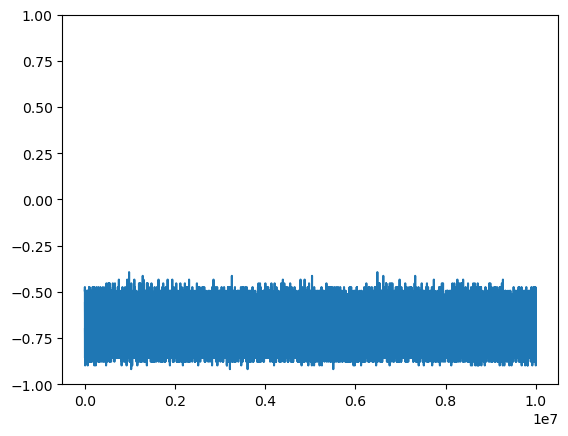

In [85]:
dyn = Dynamics(barrier)
dyn.dynamics(10000000)

print(dyn.acceptance_prob)
plt.plot(dyn.time,dyn.trajectory)
plt.ylim(-1,1)


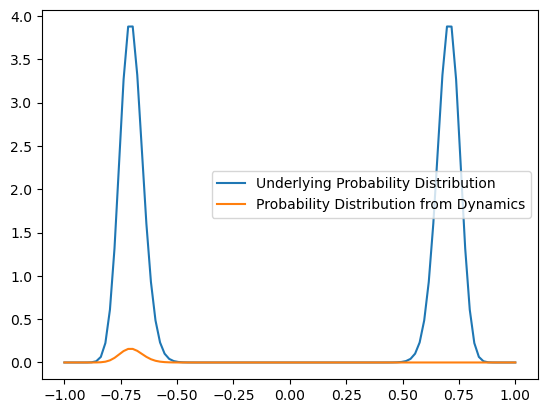

In [86]:
hist, _ = np.histogram(dyn.trajectory,range=(-1,1),bins=100)

prob_hist = hist/hist.sum()

plt.plot(dyn.x_vals,dyn.underlying_prob_dist,label='Underlying Probability Distribution')
plt.plot(dyn.x_vals,prob_hist,label='Probability Distribution from Dynamics')
plt.legend()

/tmp/ipykernel_5849/1052314490.py:1: RuntimeWarning: divide by zero encountered in log
  sampled_fes = -np.log(prob_hist)


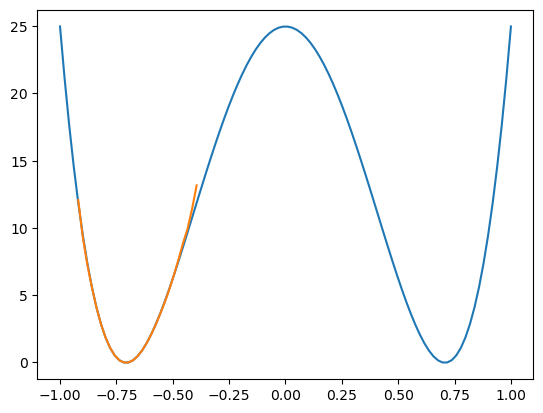

In [87]:
sampled_fes = -np.log(prob_hist)
plt.plot(dyn.x_vals,dyn.underlying_fes-dyn.underlying_fes.min())
plt.plot(dyn.x_vals,sampled_fes-sampled_fes.min())

In [81]:
umb = Umbrella_sampling(15,500,barrier)
umb.dynamics(100000)

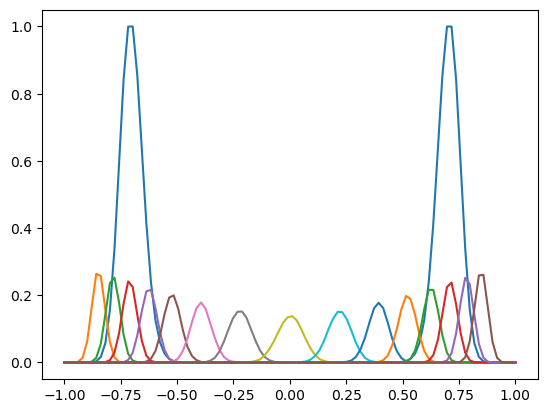

In [82]:
x_vals = umb.replicas[0].x_vals
fes = barrier(x_vals)
fes = fes - fes.min()
fes = barrier(x_vals)
fes = fes - fes.min()
prob_dist = np.exp(-fes)
plt.plot(x_vals, prob_dist)

for i in range(umb.numbrellas):
    hist, _ = np.histogram(umb.replicas[i].trajectory,range=(-1,1),bins=100)
    hist = hist/hist.sum()
    plt.plot(x_vals,hist)

In [ ]:
wham = WHAM(umb,iterations=1000)

/tmp/ipykernel_5849/4120546453.py:125: RuntimeWarning: divide by zero encountered in log
  self.G = -np.log(self.p)


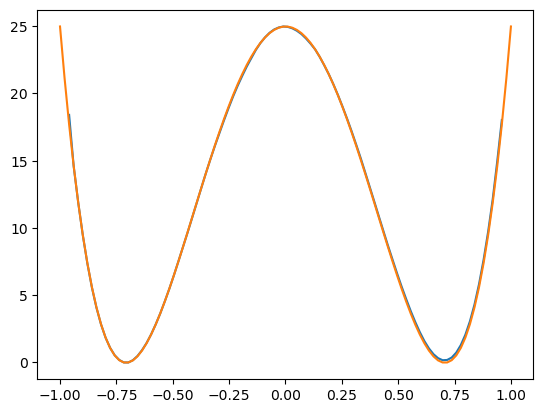

In [84]:
x_vals = umb.replicas[0].x_vals
fes = barrier(x_vals)
plt.plot(x_vals,wham.G-wham.G.min())
plt.plot(x_vals,fes-fes.min())

$p_{ij}$ is the biased probability in the j-th bin in the i-th simulation.

$p_j^{\circ}$ is the unbiased probability of bin j.

The two are related by the following equation:

$$p_{ij} = f_ic_{ij}p_j^{\circ}$$

$c_{ij}$ is the biasing factor and $f_i$ is a normalization constant such that $\sum_{j}p_{ij} = 1$. ($f_i^{-1} = \sum_jc_{ij}p_j^{\circ}$).

When a coordinate is biased $c_{ij} = \exp[-\beta V_i(x_j)]$.

It has been derived that the optimal estimate for $p_j^{\circ}$ is

$$p_j^{\circ} = \frac{\sum_{i=1}^S n_{ij}}{\sum_{i=1}^S N_if_ic_{ij}}$$

$n_{ij}$ is the number of couknts in bin j for simulation i. $N_i$ is the number of samples in the $i$-th simulation.